# jet_pre-training.ipynb

This is code (in progress) for doing pre-training on jet selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Lambda, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from clr_callback import *
from IPython.display import clear_output
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

## Load Files

In [2]:
# Data type we want to use
data_type = 'parton_e+mjets_addon_ttbar+jetMatch04_train'

# Dataset to train and test on
dataset = h5py.File('/data/jchishol/ML_Data/variables_ttbar_'+data_type+'.h5','r')

# Numpy array of [max,mean] for each variable
X_maxmean = np.load('X_maxmean_'+data_type+'.npy')
Y_maxmean = np.load('Y_maxmean_'+data_type+'.npy')

## Useful Variables

In [3]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag','j2_pt', 'j2_eta', 'j2_phi', 'j2_m','j2_isbtag','j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m','ttbar_pt','ttbar_eta','ttbar_phi','ttbar_m','j1_isTruth','j2_isTruth','j3_isTruth','j4_isTruth','j5_isTruth','j6_isTruth']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))
isTruth_keys = list(filter(lambda a: 'isTruth' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes

print(crop0)

9348801


## Scale the Data

In [4]:
import normalize
import shape_timesteps

# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

# Also, for jet pretraining, we only want the truth values of the jets (hoping this is correct way to grab the data)
Y_total = Y_total[:,-6:]
Y_names = Y_names[-6:]

## Split the Data

In [5]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
split = int(np.floor(0.82*crop0))  # Taking ~82% for training and ~18% for validation amounts to ~70% of total being training and ~15% of total being validation

# Split Y variables in training and validation 
trainY, valY = Y_total[0:split,:], Y_total[split:,:]


# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into training and validation data for jets and other
trainX_jets, valX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, valX_other = totalX_other[0:split,:], totalX_other[split:,:]

In [18]:
len(np.where(trainY[:,1]==0.)[0])/len(trainY[:,1])

0.18266476354862812

In [28]:


for i in range(6):
    print(i)
    print(len(np.where(trainY[:,i]==1.)[0])/len(trainY[:,i]))
    print(len(np.where(valY[:,i]==1.)[0])/len(valY[:,i]))

0
0.7983207966171738
0.7984644503011377
1
0.8173352364513718
0.8172107547904218
2
0.7635915448128467
0.7640886981997106
3
0.6507189653661041
0.6501282100803133
4
0.2623919647441383
0.2615123144073664
5
0.08590263834565438
0.085763184245165


## Build Model

In [6]:
#def custom_activation(x):
#    return (K.sigmoid(x) * 5) - 1

#get_custom_objects().update({'custom_activation': Activation(custom_activation)})

#Heaviside (Unit Step) function with grad
# @tf.custom_gradient
# def heaviside(X):
#   List = []

#   for I in range(6):
#     Item = tf.cond(X[I]<0, lambda: tf.constant([0], tf.float32), lambda: tf.constant([1], tf.float32))
#     List.append(Item)

#   U = tf.stack(List)

#   #Heaviside half-maximum formula
#   #U = (tf.sign(X)+1)/2;

#   #Div is differentiation intermediate value
#   def grad(Div):
#     return Div*1; #Heaviside has no gradient, use 1.

#   return U,grad

# @tf.custom_gradient
# def binary_activation(x):

#     print(x)
#     print(tf.shape(x))
#     print(x.dtype.base_dtype)

#     ones = tf.ones(tf.shape(x), dtype=x.dtype.base_dtype)
#     zeros = tf.zeros(tf.shape(x), dtype=x.dtype.base_dtype)

#     def grad(dy):
#         return dy  # TODO define gradient
#     return keras.backend.switch(x > 0.5, ones, zeros), grad

#def custom_activation(x):
#    return (K.sigmoid(x) * 5) - 1



def build_pretrain_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))   # Input n jets, each with 6 variables (n,6)
    other_input = Input(shape=(trainX_other.shape[1]))       # Input other data
    flat_jets =  Flatten()(jet_input)                        # Flatten jet input to an array of length 6n
    concat0 = concatenate([other_input, flat_jets])          # Concatenate the other and jet data
    PreDense1 = Dense(256, activation='relu')(concat0)       # Input concatenated data to dense layer of 256 nodes
    PreDense2 = Dense(256, activation='relu')(PreDense1)     # Then to another dense layer of 256 nodes
    output = Dense(trainX_jets.shape[1],activation='sigmoid')(PreDense2)    # Finally to a dense layer that outputs n numbers between 0 and 1
    #output = Lambda(lambda x: round(x))(PreOutput)
    #output = Lambda(lambda x: K.round(x)) (PreOutput)
    #output = custom_activation(PreOutput)

    # Optimization stuff?
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Create and compile the model
    pretrain_model = keras.models.Model(inputs=[jet_input, other_input], outputs=output) 
    pretrain_model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])

    return pretrain_model


pretrain_model = build_pretrain_model()
pretrain_model.summary()
keras.utils.plot_model(pretrain_model,to_file='Model_Jet_Pre-training.png',show_shapes=True,show_dtype=True,show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 43)           0           ['input_2[0][0]',                
                                                                  'flatten[0][0]']            

2022-06-15 09:07:06.442835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-06-15 09:07:06.442861: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-15 09:07:06.443160: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [7]:
# From: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5

# Function for plotting the learning as the model trains
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        print('\n')
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

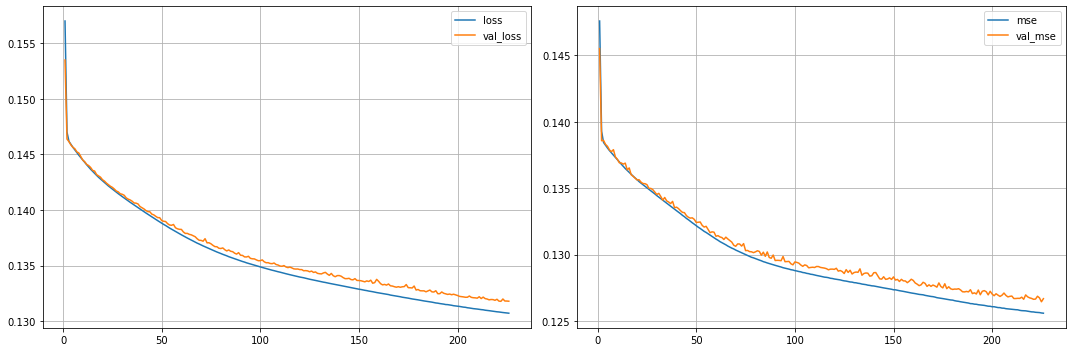

7667/7667 [==============================] - 43s 6ms/step - loss: 0.1307 - mse: 0.1256 - val_loss: 0.1318 - val_mse: 0.1267


In [8]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  # patience=4 means stop training after 4 epochs with no improvement
clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)

# Set number of epochs (runs through?)
Epochs= 256

## Fit the model (i.e. TRAIN the model)
history = pretrain_model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY), shuffle=True, callbacks=[early_stop,PlotLearning()],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)


# model.save_weights('')?

In [21]:
# Predict using un-scaled variables
pretrain_model = keras.models.load_model('Model_Jet_Pre-train.keras')
predictions_unscaled = pretrain_model.predict([valX_jets, valX_other])
true_unscaled = valY 

# Unscale the scaled predictions
#predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
#true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

2022-06-16 10:32:11.507776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-06-16 10:32:11.507800: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-16 10:32:11.508061: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [31]:
predictions_unscaled.shape

(1682785, 6)

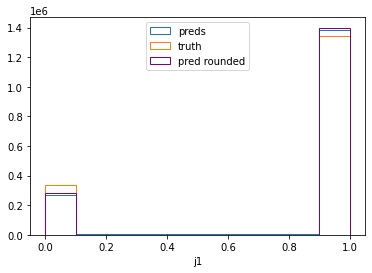

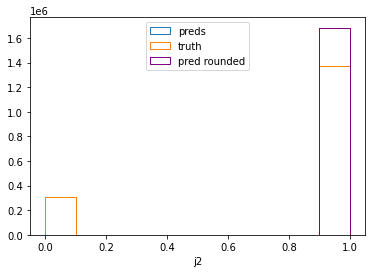

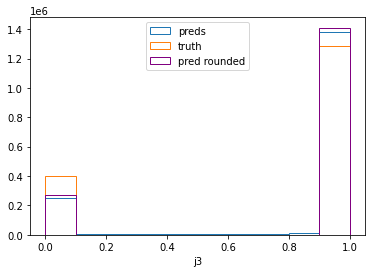

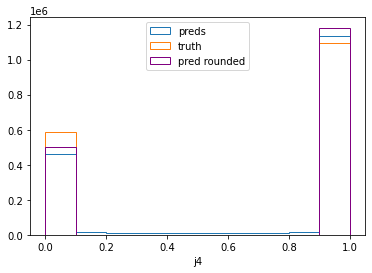

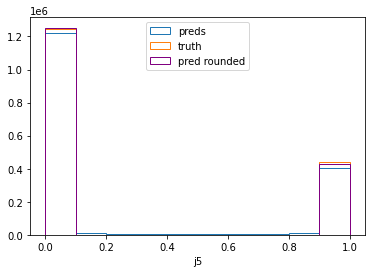

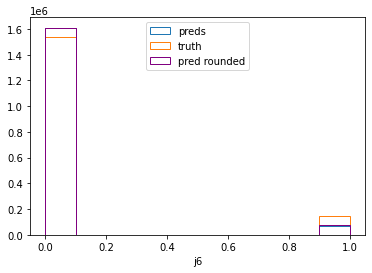

In [26]:
for i in range(6):
    plt.figure('j'+str(i+1))
    plt.hist(predictions_unscaled[:,i],bins=10,range=(0,1),histtype='step',label='preds')
    plt.hist(true_unscaled[:,i],bins=10,range=(0,1),histtype='step',label='truth')
    plt.hist(np.round(predictions_unscaled[:,i]),bins=10,range=(0,1),histtype='step',label='pred rounded',color='purple')
    plt.xlabel('j'+str(i+1))
    plt.legend(loc='upper center')